In [1]:
%pip install rasterio

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install scikit-image

Note: you may need to restart the kernel to use updated packages.


In [3]:
# processing and reading images
import zipfile
import requests
import io
from PIL import Image
from skimage.color import rgb2gray
#from tensorflow.keras.preprocessing.image import load_img, img_to_array
import rasterio
from rasterio.plot import show, show_hist

# tensor processing
import numpy as np
import os
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer

# plotting
import matplotlib.pyplot as plt
from keras.utils import plot_model

# modeling
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras.applications import vgg16
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# evaluation metrics
from sklearn.metrics import classification_report
import pandas as pd

In [4]:
# RGB file URL
url = "http://madm.dfki.de/files/sentinel/EuroSAT.zip"

# download zip
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))

In [5]:
# get file names
txtfiles = []
for file in z.namelist():
  txtfiles.append(file)

# keep only those containing ".jpg"
txtfiles = [x for x in txtfiles if ".jpg" in x]

In [6]:
# read images to numpy array
XImages = np.zeros([len(txtfiles), 64, 64, 3])

i = 0
for pic in txtfiles:
  XImages[i] = np.asarray(Image.open(z.open(pic))).astype('uint8')/255
  i += 1

In [7]:
del r # clear memory
del z

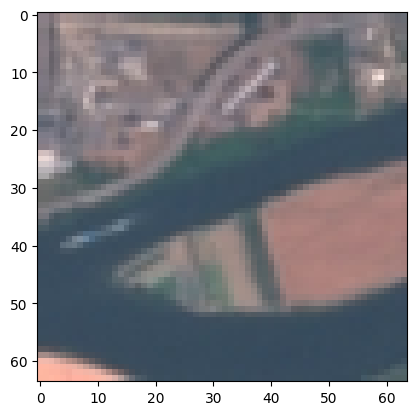

In [8]:
# Assuming XImages is your array of images
img_index = 122  # Index of the image you want to plot

# Plot the image
plt.imshow(XImages[img_index])

# Show the plot
plt.show()

In [9]:
# Get labels in numpy array as strings
labs = np.empty(len(txtfiles), dtype = 'S20')

i = 0
for label in txtfiles:
  labs[i] = label.split('/')[1]
  i += 1

print(labs.shape)
print(XImages.shape)

(27000,)
(27000, 64, 64, 3)


In [10]:
# change them to integers in alphabetical order
label_names, yLabels = np.unique(labs, return_inverse=True)

label_Dict = dict(zip(np.unique(yLabels), label_names))
print(label_Dict)
np.array(np.unique(yLabels, return_counts=True)).T

{0: b'AnnualCrop', 1: b'Forest', 2: b'HerbaceousVegetation', 3: b'Highway', 4: b'Industrial', 5: b'Pasture', 6: b'PermanentCrop', 7: b'Residential', 8: b'River', 9: b'SeaLake'}


array([[   0, 3000],
       [   1, 3000],
       [   2, 3000],
       [   3, 2500],
       [   4, 2500],
       [   5, 2000],
       [   6, 2500],
       [   7, 3000],
       [   8, 2500],
       [   9, 3000]], dtype=int64)

0
b'AnnualCrop'


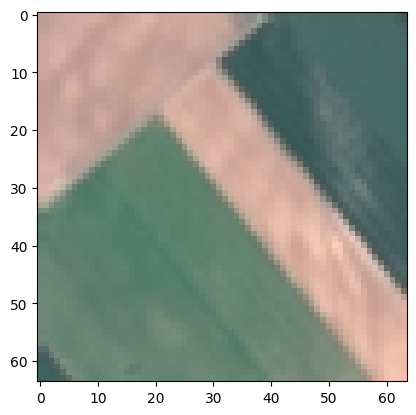

In [11]:
# test that the labels and images read in properly
tmp = 3567
img = XImages[tmp]

print(yLabels[tmp])
print(label_names[yLabels[tmp]])
plt.imshow(img);

In [12]:
# find the smallest class
smallest_class = np.argmin(np.bincount(yLabels))
smallest_class

5

In [13]:
# number of classes
num_classes = len(np.array(np.unique(yLabels)))
# observations in smallest class
smallest_class_obs = np.where(yLabels == smallest_class)[0]

# Get 2000 observations from each class
indBal = np.empty(0, dtype=int)
for i in range(num_classes):
  indTemp = shuffle(np.where(yLabels == i)[0], random_state=42)[0:smallest_class_obs.shape[0]]
  indBal = np.concatenate([indBal, indTemp])

# shuffle the balanced index
indBal = shuffle(indBal, random_state = 42)

In [14]:
yBal = yLabels[indBal]
XBal = XImages[indBal]

print(yBal.shape)
print(XBal.shape)

(20000,)
(20000, 64, 64, 3)


In [15]:
# first line uses balanced labels
# second line uses original imbalanced labels

X_train, X_test, y_train, y_test = train_test_split(XBal, yBal, stratify = yBal, train_size = 0.75, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(XImages, yLabels, stratify = yLabels, train_size = 0.5, random_state=42)

b'Highway'


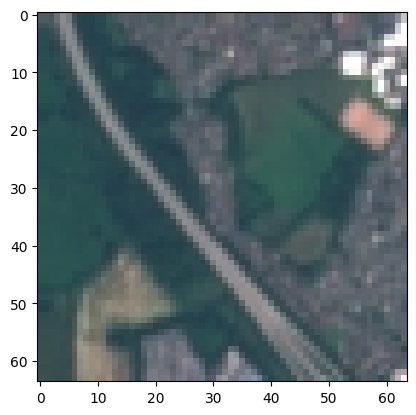

In [16]:
# test that the labels and images are still matched up properly
tmp = 123
img = X_train[tmp]

print(label_names[y_train[tmp]])
plt.imshow(img);

In [17]:
# class distribution for yTrain
np.array(np.unique(y_train, return_counts=True)).T

array([[   0, 1500],
       [   1, 1500],
       [   2, 1500],
       [   3, 1500],
       [   4, 1500],
       [   5, 1500],
       [   6, 1500],
       [   7, 1500],
       [   8, 1500],
       [   9, 1500]], dtype=int64)

In [18]:
# class distribution for yTest
np.array(np.unique(y_test, return_counts=True)).T

array([[  0, 500],
       [  1, 500],
       [  2, 500],
       [  3, 500],
       [  4, 500],
       [  5, 500],
       [  6, 500],
       [  7, 500],
       [  8, 500],
       [  9, 500]], dtype=int64)

In [19]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [20]:
import keras

# Define the file path for saving the model
model_file = r"C:\Users\nandi\Documents\FinalModel.keras"

# Configure ModelCheckpoint callback to save the best model based on validation loss
checkpoint = keras.callbacks.ModelCheckpoint(filepath=model_file,
                                              monitor='val_loss',
                                              save_best_only=True)

# List of callbacks to be used during model training
callback_list = [checkpoint]


In [21]:
batch_size = 64
epochs = 25

In [22]:
input_shape = X_train.shape[1:]

In [23]:
conv_base = vgg16.VGG16(include_top=False,
            input_shape = input_shape)

In [24]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# how many weights are trainable in the VGG16 model?
len(conv_base.trainable_weights)

26

In [26]:
# Freeze the weights of the VGG16 model
for layer in conv_base.layers:
    layer.trainable = False


In [27]:
# now there are 0
len(conv_base.trainable_weights)

0

In [28]:
from keras.models import Model
from keras.layers import Input, Flatten, Dropout, Dense

# Define input tensor
input_tensor = Input(shape=input_shape)

# Pass input tensor through the convolutional base
x = conv_base(input_tensor)

# Flatten the output
x = Flatten()(x)

# Add dropout layer
x = Dropout(0.5)(x)

# Add fully connected layer
x = Dense(512, activation='relu')(x)

# Output layer
output_tensor = Dense(10, activation='softmax')(x)

# Create the model
M6 = Model(inputs=input_tensor, outputs=output_tensor)

# Display model summary
M6.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,768,906 (60.15 MB)

 Trainable params: 1,054,218 (4.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [29]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [30]:
#%pip install pydot


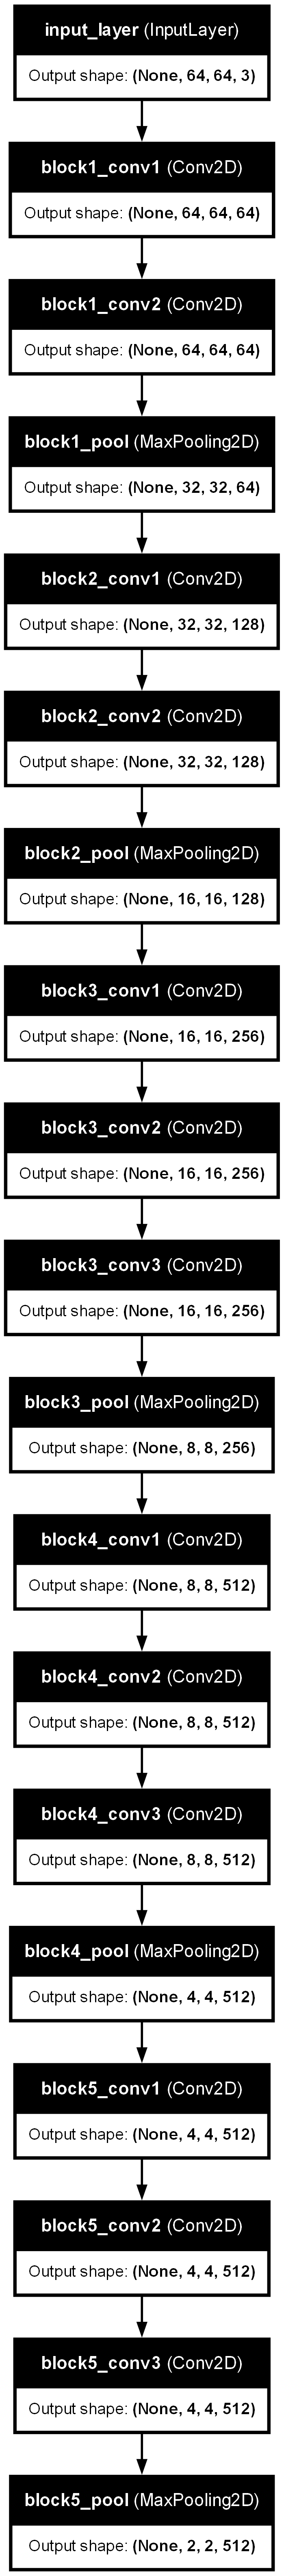

In [31]:
plot_model(conv_base, show_shapes=True, show_layer_names=True)

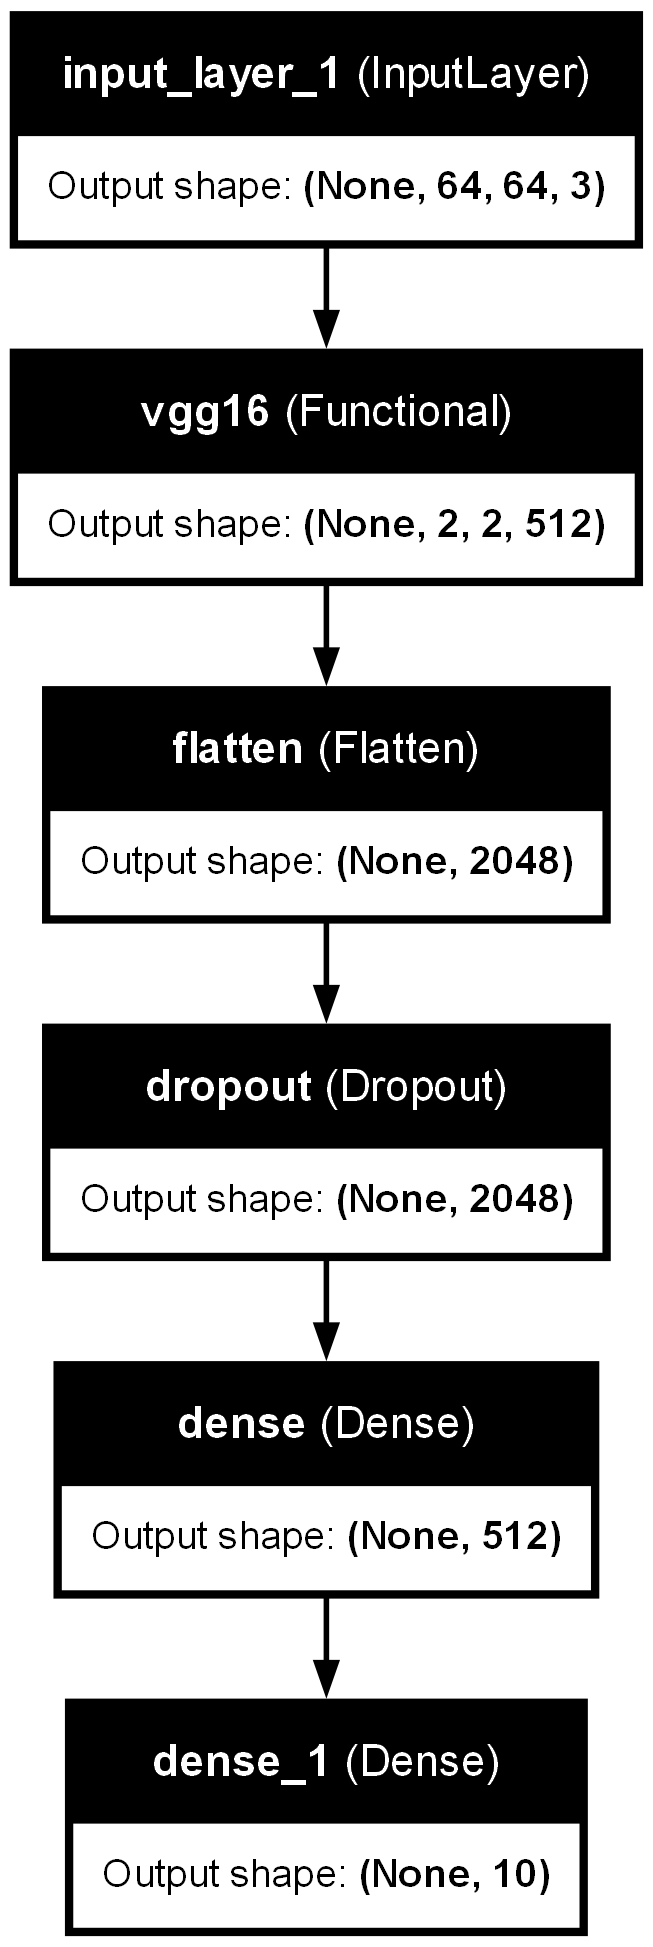

In [32]:
plot_model(M6, show_shapes=True, show_layer_names=True)

In [33]:
M6.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [34]:
history = M6.fit(X_train, y_train,
                    batch_size=64,
                    epochs=3,
                     callbacks = callback_list,
                    verbose=1,
                    validation_data=(X_test, y_test))

Epoch 1/3
235/235 ━━━━━━━━━━━━━━━━━━━━ 203s 861ms/step - accuracy: 0.5576 - loss: 1.2980 - val_accuracy: 0.7886 - val_loss: 0.5976
Epoch 2/3
235/235 ━━━━━━━━━━━━━━━━━━━━ 189s 804ms/step - accuracy: 0.7355 - loss: 0.7426 - val_accuracy: 0.7950 - val_loss: 0.5856
Epoch 3/3
235/235 ━━━━━━━━━━━━━━━━━━━━ 200s 853ms/step - accuracy: 0.7615 - loss: 0.6695 - val_accuracy: 0.8064 - val_loss: 0.5476


In [ ]:
score = M6.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

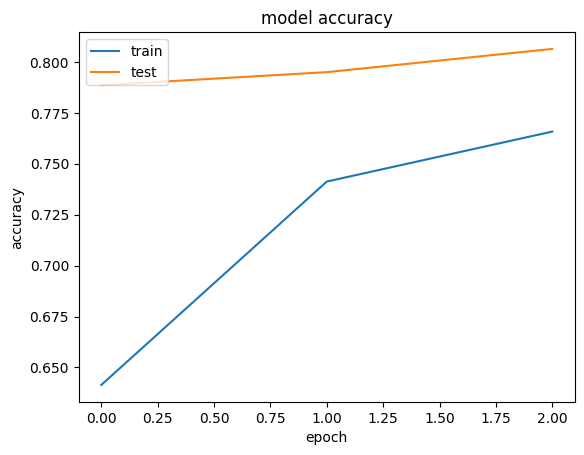

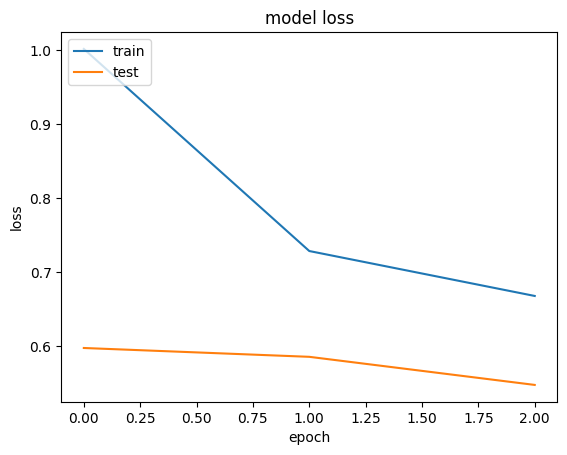

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [39]:
# unfreeze the latter 2/3ds of the base
for layer in conv_base.layers[7:]:
  layer.trainable = True

In [40]:
len(conv_base.trainable_weights)

18

In [41]:
# set a lower learning rate to minimize magnitude of changes to weights
M6.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(1e-4),
              metrics=['accuracy'])

In [42]:
history = M6.fit(X_train, y_train,
                    batch_size=64,
                    epochs=10,
                    verbose=1,
                    validation_data=(X_test, y_test))

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 399s 2s/step - accuracy: 0.4235 - loss: 2.0278 - val_accuracy: 0.7442 - val_loss: 0.8505
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 499s 2s/step - accuracy: 0.8055 - loss: 0.6161 - val_accuracy: 0.8176 - val_loss: 0.5593
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 452s 2s/step - accuracy: 0.8798 - loss: 0.3915 - val_accuracy: 0.8760 - val_loss: 0.4169
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 384s 2s/step - accuracy: 0.9098 - loss: 0.3062 - val_accuracy: 0.8900 - val_loss: 0.3653
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 400s 2s/step - accuracy: 0.9293 - loss: 0.2276 - val_accuracy: 0.8794 - val_loss: 0.3600
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 370s 2s/step - accuracy: 0.9384 - loss: 0.1907 - val_accuracy: 0.9536 - val_loss: 0.1533
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 406s 2s/step - accuracy: 0.9509 - loss: 0.1569 - val_accuracy: 0.9018 - val_loss: 0.3640
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 406s 2s/step - accuracy: 0.9548 - loss: 0.1469 - val_accu

In [44]:
score = M6.evaluate(X_test, y_test, verbose=2)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

157/157 - 42s - 268ms/step - accuracy: 0.8270 - loss: 0.7142
Test loss: 0.7142261266708374
Test accuracy: 0.8270000219345093


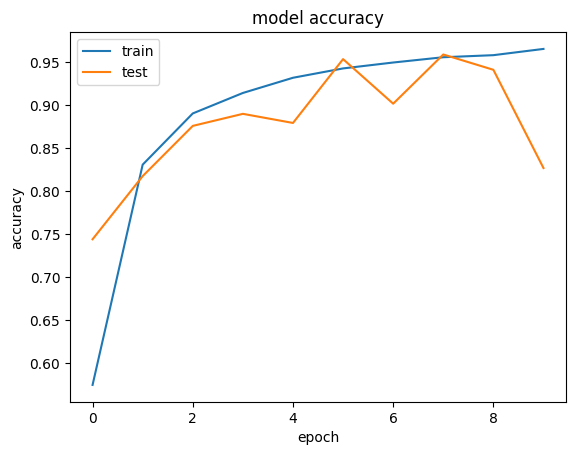

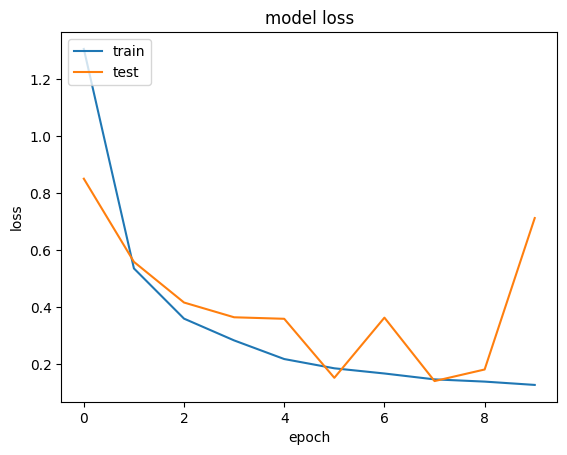

In [45]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [47]:
M6.save("model_run_2.keras")

print("Model saved successfully.")

Model saved successfully.


In [50]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def preprocess_image(image_path, target_size=(64, 64)):
    img = load_img(image_path, target_size=target_size)
    x = img_to_array(img)
    x = x.astype('float32') / 255.
    x = np.expand_dims(x, axis=0)
    return x



In [54]:
x=preprocess_image('PermanentCrop_15.jpg')

In [55]:
predictions = M6.predict(x)
predictions[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


array([1.1035761e-02, 1.1682170e-04, 1.1144687e-02, 7.8196954e-03,
       1.0984039e-02, 6.1768740e-03, 9.5013791e-01, 8.7203144e-04,
       1.5134613e-03, 1.9874750e-04], dtype=float32)

In [57]:
index=(np.argmax(predictions))
labels = {0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway',4:'Industrial',5:'Pasture',6:'PermanentCrop',7:'Residential',8:'River',9:'SeaLake'}

# Printing the dictionary
print(labels[index])

PermanentCrop
